In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# Load the datasets
df_train = pd.read_csv('loan_train.csv')
df_test = pd.read_csv('loan_test.csv')

print("Train Data Shape:", df_train.shape)
print("Test Data Shape:", df_test.shape)

Train Data Shape: (614, 13)
Test Data Shape: (367, 12)


In [5]:
# Check how many missing values are in each column
print("Missing values before cleaning:")
print(df_train.isnull().sum())

Missing values before cleaning:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [6]:
# Function to fill missing values
def fill_missing(df):
    df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
    df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median())
    df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])
    
    # Fill categorical columns with Mode
    cat_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed']
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

# Apply to both datasets
df_train = fill_missing(df_train)
df_test = fill_missing(df_test)

print("Missing values handled.")

Missing values handled.


In [7]:
def feature_engineering(df):
    # 1. Create Total Income
    df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

    # 2. Log Transformation (Normalization)
    df['LoanAmount_Log'] = np.log(df['LoanAmount'])
    df['Total_Income_Log'] = np.log(df['Total_Income'])

    # 3. Drop old raw columns & ID
    cols_to_drop = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Total_Income']
    if 'Loan_ID' in df.columns:
        cols_to_drop.append('Loan_ID')
        
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    return df

# Apply to both
df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)

print("Feature Engineering Complete.")
display(df_train.head())

Feature Engineering Complete.


,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_Log,Total_Income_Log
0,Male,No,0,Graduate,No,360.0,1.0,Urban,Y,4.852030,8.674026
1,Male,Yes,1,Graduate,No,360.0,1.0,Rural,N,4.852030,8.714568
2,Male,Yes,0,Graduate,Yes,360.0,1.0,Urban,Y,4.189655,8.006368
3,Male,Yes,0,Not Graduate,No,360.0,1.0,Urban,Y,4.787492,8.505323
4,Male,No,0,Graduate,No,360.0,1.0,Urban,Y,4.948760,8.699515


In [8]:
df_train['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [9]:
# Initialize Encoder
le = LabelEncoder()

cols_to_encode = ['Gender', 'Married', 'Dependents', 'Education',
                  'Self_Employed', 'Property_Area']

# Encode Train
for col in cols_to_encode:
    df_train[col] = le.fit_transform(df_train[col])

# Encode Target specifically
df_train['Loan_Status'] = le.fit_transform(df_train['Loan_Status'])

# Encode Test (using same logic)
for col in cols_to_encode:
    df_test[col] = le.fit_transform(df_test[col])

print("Data encoded successfully!")

Data encoded successfully!


In [10]:
df_train['Gender'].unique()

array([1, 0])

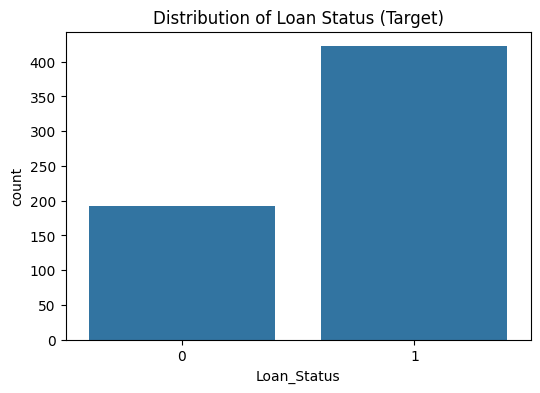

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Loan_Status', data=df_train)
plt.title('Distribution of Loan Status (Target)')
plt.show()

In [12]:
# Define Features (X) and Target (y)
X = df_train.drop('Loan_Status', axis=1)
y = df_train['Loan_Status']

# Split 80/20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Shape:", X_train.shape)
print("Validation Shape:", X_val.shape)

Training Shape: (491, 10)
Validation Shape: (123, 10)


In [13]:
# Tuned Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,        # More trees
    max_depth=10,            # Prevent overfitting
    class_weight='balanced', # Improve Recall for 'Rejected' loans
    random_state=42
)

rf_model.fit(X_train, y_train)
print("Tuned Model Trained.")

Tuned Model Trained.


Validation Accuracy: 76.42%

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.42      0.55        43
           1       0.75      0.95      0.84        80

    accuracy                           0.76       123
   macro avg       0.79      0.68      0.70       123
weighted avg       0.78      0.76      0.74       123



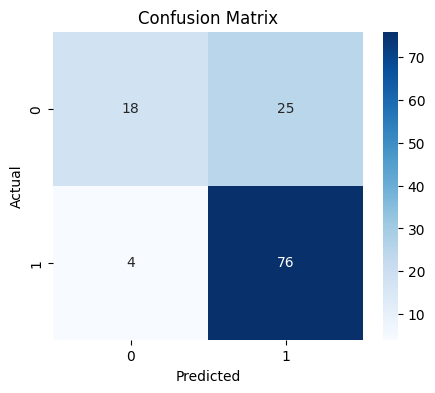

In [14]:
# Predictions on Validation Set
y_pred = rf_model.predict(X_val)

# Accuracy
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Visual Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [15]:
joblib.dump(rf_model, 'loan_model.joblib')
print("Model saved as 'loan_model.joblib'")

Model saved as 'loan_model.joblib'


In [16]:
# Predict on the real test file
final_predictions = rf_model.predict(df_test)

# We need the original IDs for submission. 
# Since we dropped them from df_test, we read the original file again just to get IDs.
test_ids = pd.read_csv('loan_test.csv')['Loan_ID']

# Create Submission DataFrame
submission = pd.DataFrame({
    'Loan_ID': test_ids,
    'Loan_Status': final_predictions
})

# Convert 1/0 back to Y/N
submission['Loan_Status'] = submission['Loan_Status'].map({1: 'Y', 0: 'N'})

# Save
submission.to_csv('final_submission.csv', index=False)
print("Final predictions saved to 'final_submission.csv'")
print(submission.head())

Final predictions saved to 'final_submission.csv'
    Loan_ID Loan_Status
0  LP001015           Y
1  LP001022           Y
2  LP001031           Y
3  LP001035           Y
4  LP001051           Y
